<a href="https://colab.research.google.com/github/WiktorStasiak/GEM-and-Buy-Hold-Strategy-Comparison-Report/blob/colab/globalequitiesmomentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import danych

In [ ]:
%pip install numpy_financial

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as nf

sp500 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dane/gem/iShares Core S&P 500 ETF.csv")
acwi_ex_us = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dane/gem/SPDR MSCI ACWI ex-US ETF.csv")
treasury_7_10y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dane/gem/iShares 7-10 Year Treasury Bond ETF.csv")
treasury_1_3y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dane/gem/iShares 1-3 Year Treasury Bond ETF.csv")

sp500 = sp500[["Data", "Zamkniecie"]].rename(columns={"Data": "Date", "Zamkniecie": "SP500"})
acwi_ex_us = acwi_ex_us[["Data", "Zamkniecie"]].rename(columns={"Data": "Date", "Zamkniecie": "ACWI_ex_US"})
treasury_7_10y = treasury_7_10y[["Data", "Zamkniecie"]].rename(columns={"Data": "Date", "Zamkniecie": "Treasury_7_10Y"})
treasury_1_3y = treasury_1_3y[["Data", "Zamkniecie"]].rename(columns={"Data": "Date", "Zamkniecie": "Treasury_1_3Y"})

df_markets = sp500.merge(acwi_ex_us, on="Date")
df_markets["Date"] = pd.to_datetime(df_markets["Date"])
df_markets = df_markets.set_index("Date")
df_markets = df_markets[(df_markets.index >= '2007-01-31') & (df_markets.index <= '2025-07-31')]

df_bonds = treasury_7_10y.merge(treasury_1_3y, on="Date")
df_bonds["Date"] = pd.to_datetime(df_bonds["Date"])
df_bonds = df_bonds.set_index("Date")
df_bonds = df_bonds[(df_bonds.index >= '2007-01-31') & (df_bonds.index <= '2025-07-31')]

df_combined = df_markets.merge(df_bonds, on="Date")
display(df_combined.head())

,SP500,ACWI_ex_US,Treasury_7_10Y,Treasury_1_3Y
Date,,,,
2007-01-31,114.708,17.9676,67.4241,72.9880
2007-02-28,112.556,17.9243,68.5477,73.2411
2007-03-31,113.350,18.4558,68.2250,73.3258
2007-04-30,118.269,19.1783,68.3733,73.2790
2007-05-31,122.306,19.7709,67.1690,72.9711


## Wizualizacja ETF-ów

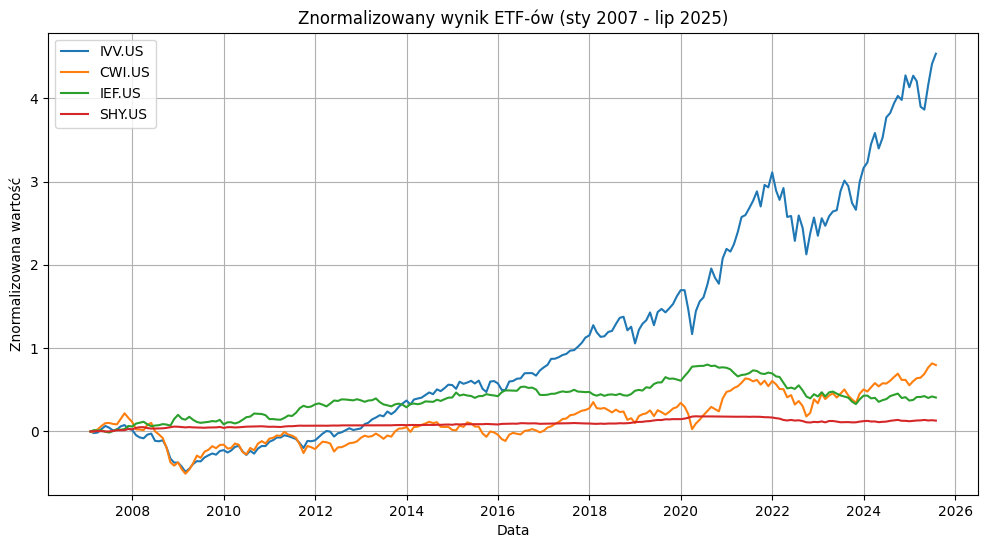

In [ ]:
df_normalized = (df_combined / df_combined.iloc[0]) - 1

new_labels = {
    "SP500": "IVV.US",
    "ACWI_ex_US": "CWI.US",
    "Treasury_7_10Y": "IEF.US",
    "Treasury_1_3Y": "SHY.US"
}

plt.figure(figsize=(12, 6))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=new_labels.get(column, column)) # Use new label if available, otherwise use original

plt.title("Znormalizowany wynik ETF-ów (sty 2007 - lip 2025)")
plt.xlabel("Data")
plt.ylabel("Znormalizowana wartość")
plt.legend()
plt.grid(True)
plt.show()

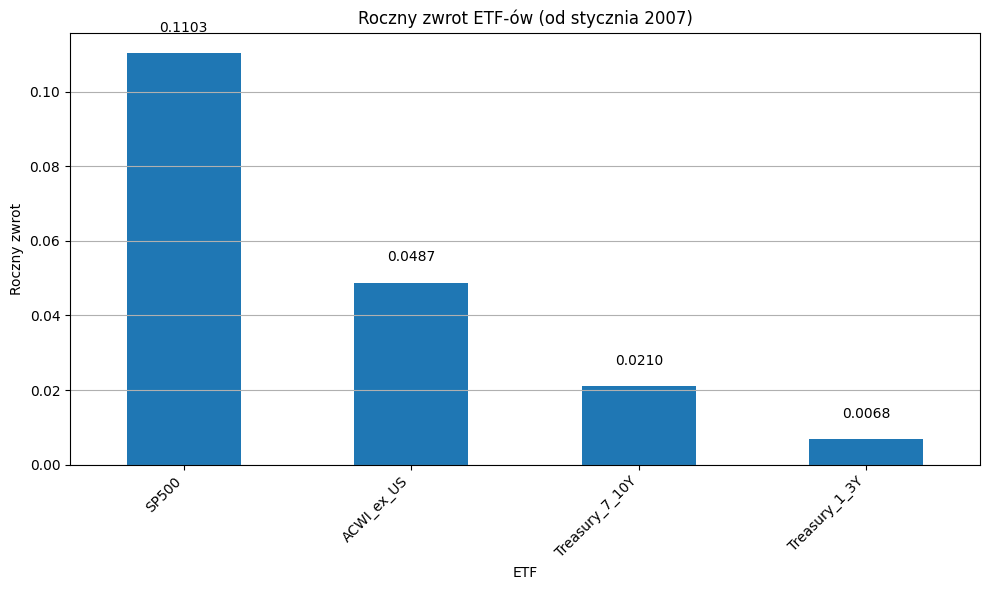

In [ ]:
returns_monthly = df_combined.pct_change().dropna()

annualized_returns = (1 + returns_monthly.mean()) ** 12 - 1

plt.figure(figsize=(10, 6))
ax = annualized_returns.plot(kind='bar')
plt.title("Roczny zwrot ETF-ów (od stycznia 2007)")
plt.xlabel("ETF")
plt.ylabel("Roczny zwrot")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()

for i, v in enumerate(annualized_returns):
    ax.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom')

plt.show()

## Symulacja strategii GEM

### Funkcja pomocnicza

In [ ]:
def calculate_performance_metrics(portfolio_values, monthly_contribution=100, freq=12):
    returns = portfolio_values.pct_change().dropna()

    cashflows = [-monthly_contribution] * len(portfolio_values)
    cashflows[-1] += portfolio_values.iloc[-1]
    irr = nf.irr(cashflows)
    annualized_return = (1 + irr) ** freq - 1

    total_contributions = monthly_contribution * len(portfolio_values)
    total_return = (portfolio_values.iloc[-1] - total_contributions) / total_contributions

    cummax = portfolio_values.cummax()
    drawdown = (portfolio_values - cummax) / cummax
    max_drawdown = drawdown.min()

    sharpe_ratio = np.sqrt(freq) * returns.mean() / returns.std()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Max Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe_ratio
    }

### Symulacja strategii GEM

In [ ]:
initial_investment = 0
monthly_contribution = 100

portfolio_gem = []
values_gem = 0

holdings = {col: 0 for col in df_combined.columns}

for date in df_combined.index[12:]:
    prev_date = date - pd.offsets.MonthBegin(1)

    momentum = df_combined.loc[date] / df_combined.shift(12).loc[date] - 1
    stock_momentum = momentum[["SP500", "ACWI_ex_US"]]
    bond_momentum = momentum[["Treasury_7_10Y", "Treasury_1_3Y"]]


    if (stock_momentum > 0).all():
        chosen_asset = stock_momentum.idxmax()
    else:
        if (bond_momentum > 0).any():
            chosen_asset = bond_momentum.idxmax()
        else:
            chosen_asset = "Treasury_1_3Y"


    monthly_price = df_combined.loc[date, chosen_asset]
    holdings[chosen_asset] += monthly_contribution / monthly_price

    values_gem = sum(holdings[asset] * df_combined.loc[date, asset] for asset in holdings)
    portfolio_gem.append((date, values_gem))

portfolio_gem = pd.Series(dict(portfolio_gem))

### Symulacja portfela Buy & Hold

In [ ]:
portfolios_bh = {}

for asset in ["SP500"]:
    units = 0
    values = []
    for date in df_combined.index[12:]:
        price = df_combined.loc[date, asset]
        units += monthly_contribution / price
        values.append((date, units * price))
    portfolios_bh[asset] = pd.Series(dict(values))

### Wizualizacja GEM

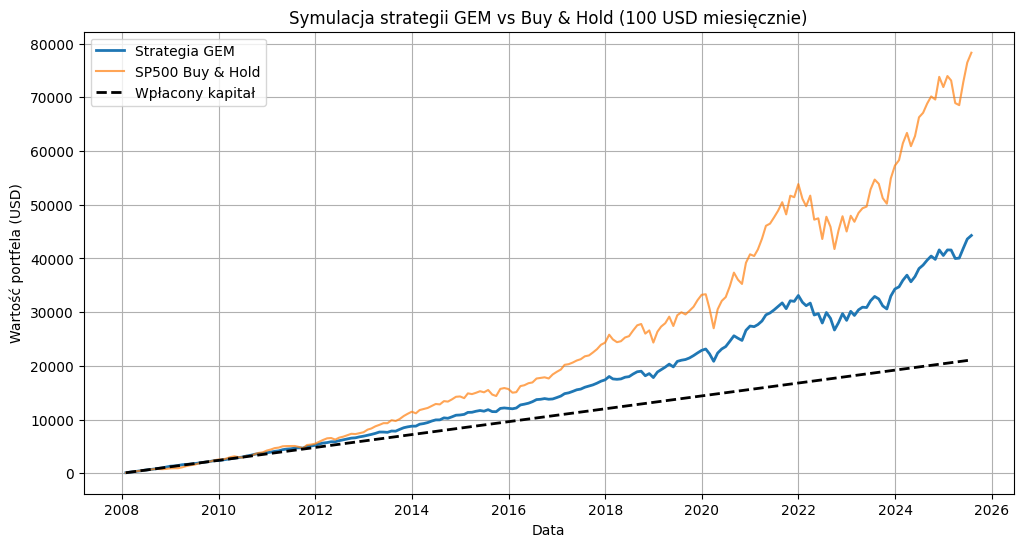

In [ ]:
capital_line = [monthly_contribution * i for i in range(1, len(df_combined.index[12:]) + 1)]

plt.figure(figsize=(12, 6))
plt.plot(portfolio_gem, label="Strategia GEM", linewidth=2)

for asset, series in portfolios_bh.items():
    plt.plot(series, label=f"{asset} Buy & Hold", alpha=0.7)

capital_line = [monthly_contribution * i for i in range(1, len(df_combined.index[12:]) + 1)]
plt.plot(df_combined.index[12:], capital_line, label="Wpłacony kapitał", linestyle="--", color="black", linewidth=2)

plt.title("Symulacja strategii GEM vs Buy & Hold (100 USD miesięcznie)")
plt.xlabel("Data")
plt.ylabel("Wartość portfela (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Metryki wydajności

In [ ]:
results = {}
results["Strategia GEM"] = calculate_performance_metrics(portfolio_gem)
for asset, series in portfolios_bh.items():
    results[f"{asset} Buy & Hold"] = calculate_performance_metrics(series)

df_results = pd.DataFrame(results).T
print("\nMetryki wydajności:")
print(df_results)


Metryki wydajności:
                  Total Return  Annualized Return  Max Drawdown  Sharpe Ratio
Strategia GEM         1.098729           0.079267     -0.194226      1.272518
SP500 Buy & Hold      2.711462           0.135457     -0.224668      1.330105


### Wykres drawdownów

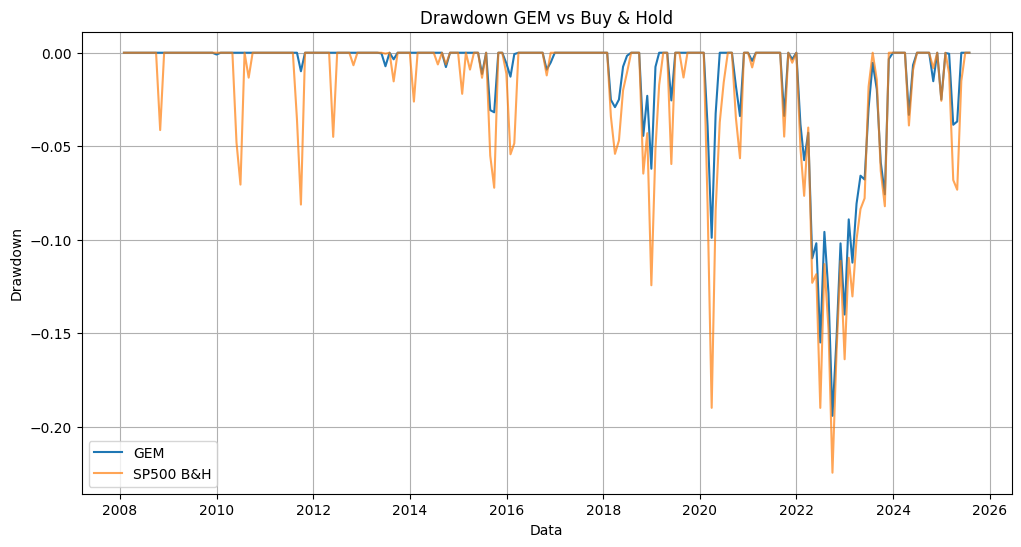

In [ ]:
def compute_drawdown(series):
    cummax = series.cummax()
    return (series - cummax) / cummax

plt.figure(figsize=(12,6))
plt.plot(compute_drawdown(portfolio_gem), label="GEM")
plt.plot(compute_drawdown(portfolios_bh["SP500"]), label="SP500 B&H", alpha=0.7)
plt.title("Drawdown GEM vs Buy & Hold")
plt.xlabel("Data")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()

### CAGR vs Max Drawdown (wykres słupkowy)

<Figure size 1000x600 with 0 Axes>

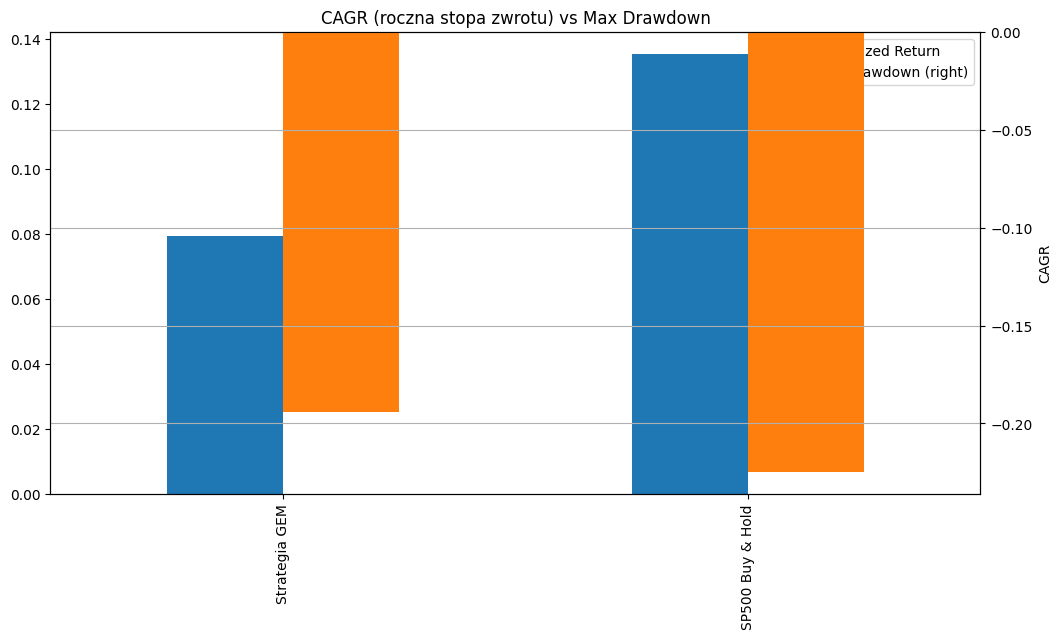

In [ ]:
plt.figure(figsize=(10,6))
df_results[["Annualized Return","Max Drawdown"]].loc[["Strategia GEM", "SP500 Buy & Hold"]].plot(
    kind="bar", secondary_y="Max Drawdown", figsize=(12,6)
)
plt.title("CAGR (roczna stopa zwrotu) vs Max Drawdown")
plt.ylabel("CAGR")
plt.grid(axis="y")
plt.show()

### Histogram miesięcznych stóp zwrotu GEM vs SP500

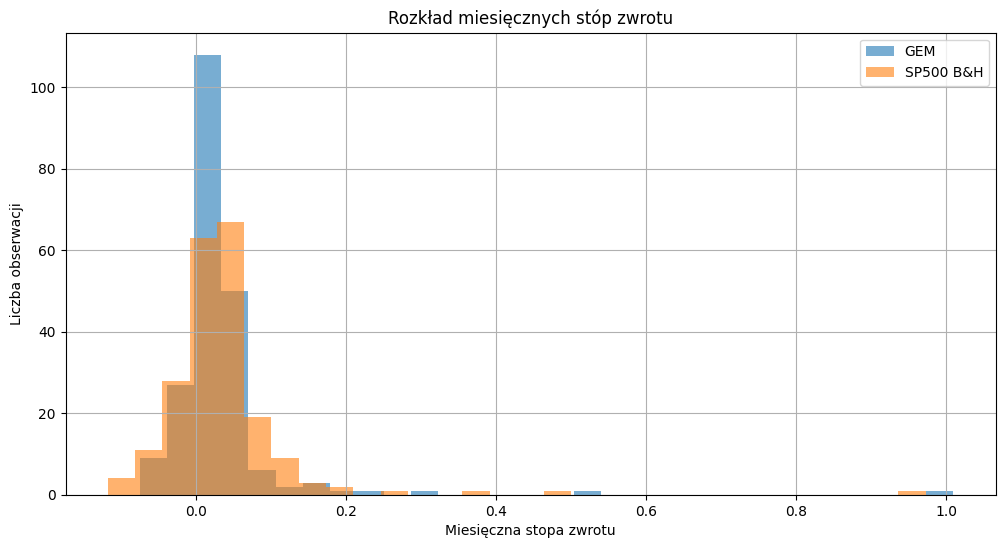

In [ ]:
gem_returns = portfolio_gem.pct_change().dropna()
sp500_returns = portfolios_bh["SP500"].pct_change().dropna()

plt.figure(figsize=(12,6))
plt.hist(gem_returns, bins=30, alpha=0.6, label="GEM")
plt.hist(sp500_returns, bins=30, alpha=0.6, label="SP500 B&H")
plt.title("Rozkład miesięcznych stóp zwrotu")
plt.xlabel("Miesięczna stopa zwrotu")
plt.ylabel("Liczba obserwacji")
plt.legend()
plt.grid(True)
plt.show()

### Tabela wyników

In [ ]:
df_results_fmt = df_results.copy()
df_results_fmt["Total Return"] = df_results_fmt["Total Return"].map("{:.1%}".format)
df_results_fmt["Annualized Return"] = df_results_fmt["Annualized Return"].map("{:.1%}".format)
df_results_fmt["Max Drawdown"] = df_results_fmt["Max Drawdown"].map("{:.1%}".format)
df_results_fmt["Sharpe Ratio"] = df_results_fmt["Sharpe Ratio"].map("{:.2f}".format)

print("\nPodsumowanie wyników:\n")
print(df_results_fmt)


Podsumowanie wyników:

                 Total Return Annualized Return Max Drawdown Sharpe Ratio
Strategia GEM          109.9%              7.9%       -19.4%         1.27
SP500 Buy & Hold       271.1%             13.5%       -22.5%         1.33


### Alokacjia aktywów w strategii GEM

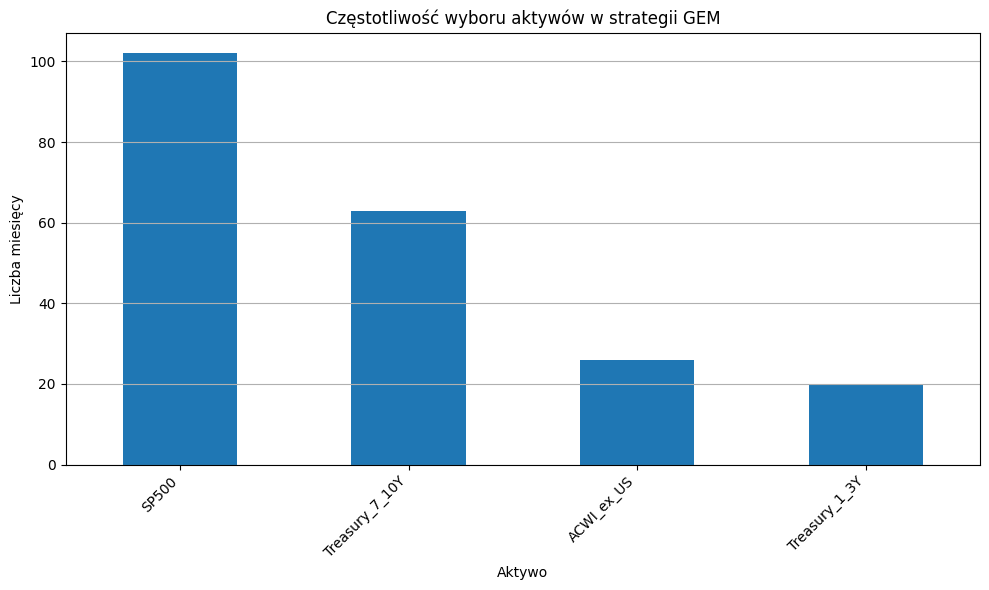

In [ ]:
gem_allocations = []

for date in df_combined.index[12:]:
    momentum = df_combined.loc[date] / df_combined.shift(12).loc[date] - 1
    stock_momentum = momentum[["SP500", "ACWI_ex_US"]]
    bond_momentum = momentum[["Treasury_7_10Y", "Treasury_1_3Y"]]

    if (stock_momentum > 0).all():
        chosen_asset = stock_momentum.idxmax()
    else:
        if (bond_momentum > 0).any():
            chosen_asset = bond_momentum.idxmax()
        else:
            chosen_asset = "Treasury_1_3Y"

    gem_allocations.append((date, chosen_asset))

gem_allocations_series = pd.Series(dict(gem_allocations))


# Wizualizacja
allocation_counts = gem_allocations_series.value_counts()

plt.figure(figsize=(10, 6))
allocation_counts.plot(kind='bar')
plt.title("Częstotliwość wyboru aktywów w strategii GEM")
plt.xlabel("Aktywo")
plt.ylabel("Liczba miesięcy")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Liczba zmian w portfelu

In [ ]:
num_switches = (gem_allocations_series != gem_allocations_series.shift(1)).sum() - 1
total_months = len(gem_allocations_series)

print(f"Liczba zamian aktywów w strategii GEM: {num_switches} na {total_months} miesięcy")

Liczba zamian aktywów w strategii GEM: 43 na 211 miesięcy


### Wizualizacja alokacji aktywów w czasie

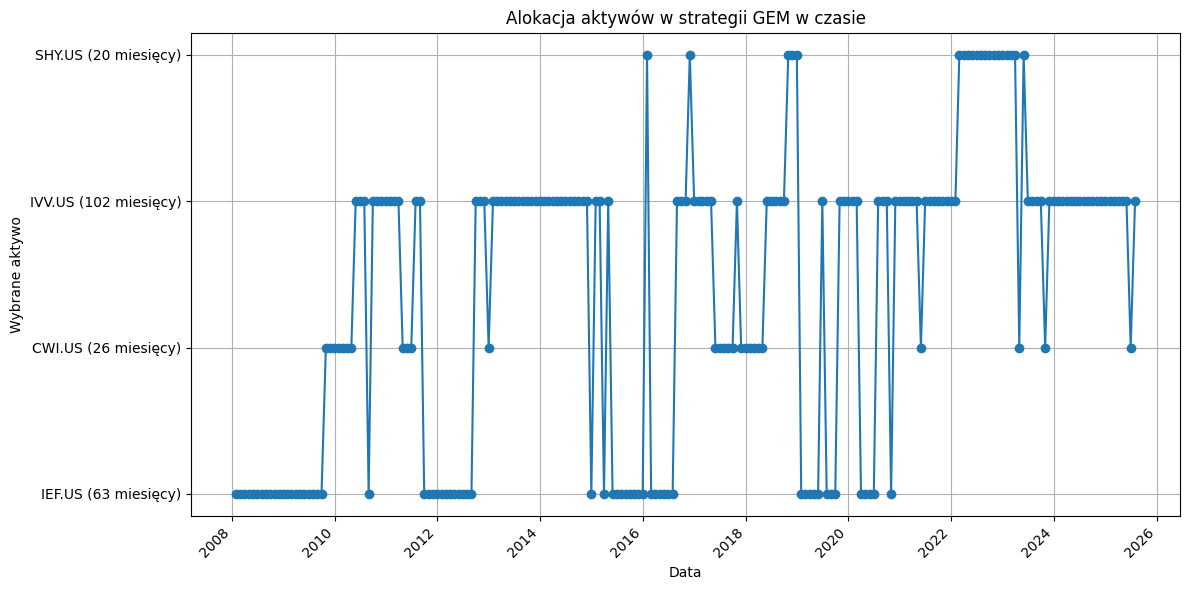

In [ ]:
new_labels = {
    "SP500": "IVV.US",
    "ACWI_ex_US": "CWI.US",
    "Treasury_7_10Y": "IEF.US",
    "Treasury_1_3Y": "SHY.US"
}

updated_labels = {}
for asset, count in allocation_counts.items():
    if asset in new_labels:
        updated_labels[asset] = f"{new_labels[asset]} ({count} miesięcy)"
    else:
        updated_labels[asset] = f"{asset} ({count} miesięcy)"


plt.figure(figsize=(12, 6))
plt.plot(gem_allocations_series.index, gem_allocations_series.values, marker='o', linestyle='-')
plt.title("Alokacja aktywów w strategii GEM w czasie")
plt.xlabel("Data")
plt.ylabel("Wybrane aktywo")
plt.yticks(list(updated_labels.keys()), list(updated_labels.values()))
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()